In [1]:
import gym
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import math ,random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from utility import ReplayBuffer, plot

In [2]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 3000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

env=gym.make('CartPole-v0')

In [3]:
class DQN(nn.Module):
    def __init__(self, num_input=1, num_actions=4):
        super(DQN, self).__init__()
        self.device=('cuda' if T.cuda.is_available() else 'cpu')
        self.ll=nn.Sequential(nn.Linear(env.observation_space.shape[0],32),
                              nn.ReLU(),
                              nn.Linear(32,32),
                              nn.ReLU(),
                              nn.Linear(32,16),
                              nn.ReLU(),
                              nn.Linear(16,env.action_space.n))
        
    def forward(self, x):
        x   = T.FloatTensor(x).to(self.device)
        
        x = self.ll(x)

        return x
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            
            q_value = self.forward(state)
            action  = T.argmax(q_value).item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [4]:
model=DQN()
model=model.to(model.device)
model_target=DQN()
model_target=model_target.to(model.device)
model_target.load_state_dict(model.state_dict())
model_target.eval()
optimizer = T.optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)
crit=nn.MSELoss()
gamma=0.999

In [5]:
def compute_loss(batch_size):
    state,action,reward,next_state,done=replay_buffer.sample(batch_size)

    state=T.FloatTensor(state)
    action=T.tensor(action).cuda()
    reward=T.tensor(reward).cuda()
    next_state=T.FloatTensor(next_state)
    done=T.tensor(done).float().cuda()

    q_values      = model(state)
    next_q_values = model(next_state).detach()

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = crit(q_value,expected_q_value)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

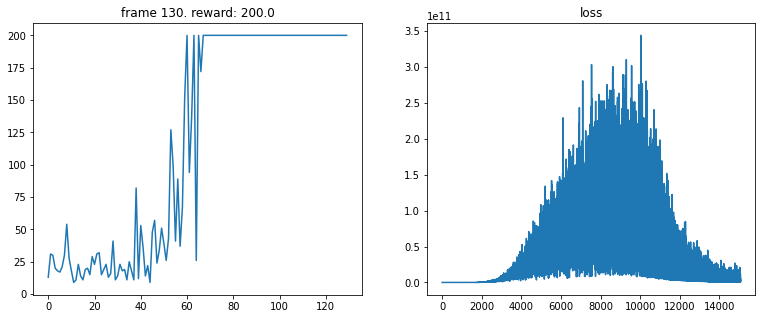

In [6]:
num_frames = 130
batch_size = 512
gamma      = 1

losses = []
all_rewards = []
episode_reward = 0
state=env.reset()
es=0
for frame_idx in range(1, num_frames + 1):
    done =0
    while not done:
        epsilon = epsilon_by_frame(es)
        es+=1
        action = model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)

        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward


            

        if len(replay_buffer) > batch_size:
            loss = compute_loss(batch_size)
            losses.append(loss.item())
    state = env.reset()
    all_rewards.append(episode_reward)
    episode_reward = 0
    if frame_idx % 5==0:
        model_target.load_state_dict(model.state_dict())
        
    plot(frame_idx, all_rewards, losses)
    
